Mounted at /content/drive


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 2494.88it/s]


✅ CSV saved to: /content/drive/MyDrive/Cluster-proj/output/stat_logits/0524/step_level_token_stats_merged_200_600.csv


<Figure size 1000x600 with 0 Axes>

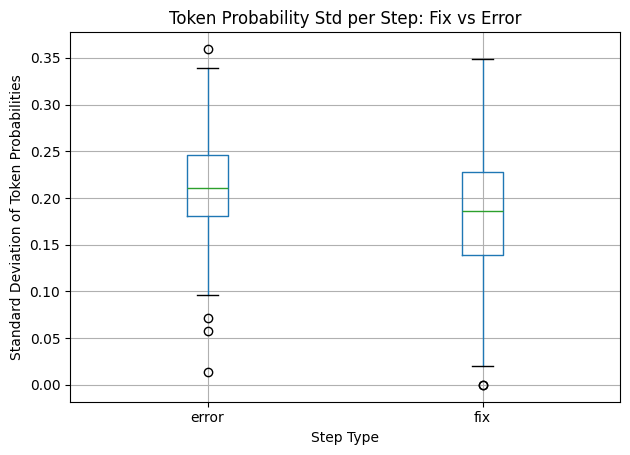

In [ ]:

# ========== 📦 Imports ==========
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')


# ========== 📂 配置 ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"  # 替换为你的本地路径或 Colab 挂载路径
OUTPUT_DIR = os.path.join(BASE_PATH, "output/stat_logits/0524")
os.makedirs(OUTPUT_DIR, exist_ok=True)


# ========== 📊 存储每个step的统计信息 ==========
step_stats = []

# ========== 🔁 合并处理所有区间 ==========
for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"
    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    with open(INFERENCE_PATH, 'r') as f:
        logits_data = json.load(f)
    with open(STEPS_PATH, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue
        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key, comparisons in entry.get(s_type, {}).items():
                for vs_key, info in comparisons.items():
                    step_key = "fix_step" if s_type == "correct_sampling" else "error_step"
                    if step_key in info:
                        step = str(info[step_key])
                        token_probs = logits_data[qid].get(sampling_key, {}).get("step_token_probs", {}).get(step, [])
                        if not token_probs:
                            continue
                        probs = [tok["prob"] for tok in token_probs if "prob" in tok]
                        if not probs:
                            continue
                        step_stats.append({
                            "qid": qid,
                            "step": step,
                            "sampling_id": sampling_key,
                            "type": "fix" if step_key == "fix_step" else "error",
                            "min_prob": np.min(probs),
                            "max_prob": np.max(probs),
                            "mean_prob": np.mean(probs),
                            "std_prob": np.std(probs),
                            "conf_span": np.max(probs) - np.min(probs),
                            "probs": probs
                        })

# ========== 🧠 倒高斯函数 ==========
def inverted_gaussian(x, mu=0, sigma=1):
    return -np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# ========== 📈 高斯参数估计 ==========
df_steps = pd.DataFrame(step_stats)
all_token_probs = np.concatenate(df_steps["probs"].values)
mu_est = np.mean(all_token_probs)
sigma_est = np.std(all_token_probs)

# ========== 📉 倒高斯打分 ==========
df_steps["avg_inverted_score"] = df_steps["probs"].apply(
    lambda probs: np.mean(inverted_gaussian(np.array(probs), mu=mu_est, sigma=sigma_est))
)

# ========== 💾 保存CSV ==========
output_csv = os.path.join(OUTPUT_DIR, "step_level_token_stats_merged_200_600.csv")
df_steps.drop(columns=["probs"]).to_csv(output_csv, index=False)
print(f"✅ CSV saved to: {output_csv}")

# ========== 📊 可视化：标准差对比 ==========
plt.figure(figsize=(10, 6))
df_steps.boxplot(column="std_prob", by="type")
plt.title("Token Probability Std per Step: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Standard Deviation of Token Probabilities")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_steps

,qid,step,sampling_id,type,min_prob,max_prob,mean_prob,std_prob,conf_span,probs,avg_inverted_score
0,q_206,6,sampling1,fix,0.574481,1.0,0.978915,0.078912,0.425519,"[1.0, 0.957912266254425, 1.0, 0.86180418729782...",-0.895126
1,q_206,3,sampling1,fix,0.179862,1.0,0.883932,0.250097,0.820138,"[1.0, 0.21506790816783905, 0.5720393657684326,...",-0.783158
2,q_206,3,sampling0,error,0.123698,1.0,0.964929,0.120305,0.876302,"[1.0, 0.7849321365356445, 1.0, 0.7129498720169...",-0.888205
3,q_206,2,sampling2,error,0.030417,1.0,0.749436,0.332074,0.969583,"[1.0, 0.030417364090681076, 0.129670649766922,...",-0.670949
4,q_208,1,sampling1,fix,0.060339,1.0,0.849925,0.269705,0.939661,"[1.0, 0.9511421918869019, 1.0, 1.0, 0.95009434...",-0.755332
...,...,...,...,...,...,...,...,...,...,...,...
363,q_594,5,sampling2,error,0.255132,1.0,0.876674,0.224855,0.744868,"[1.0, 1.0, 0.7849321365356445, 1.0, 0.26141646...",-0.754418
364,q_597,2,sampling0,fix,0.850823,1.0,0.991569,0.029400,0.149177,"[1.0, 0.9383825659751892, 0.8508228659629822, ...",-0.920049
365,q_597,2,sampling1,fix,0.890729,1.0,0.994971,0.022248,0.109271,"[1.0, 1.0, 0.8907294273376465, 1.0, 1.0, 1.0, ...",-0.918048
366,q_597,1,sampling2,error,0.138196,1.0,0.873650,0.242202,0.861804,"[1.0, 0.47528427839279175, 0.8769960999488831,...",-0.777737


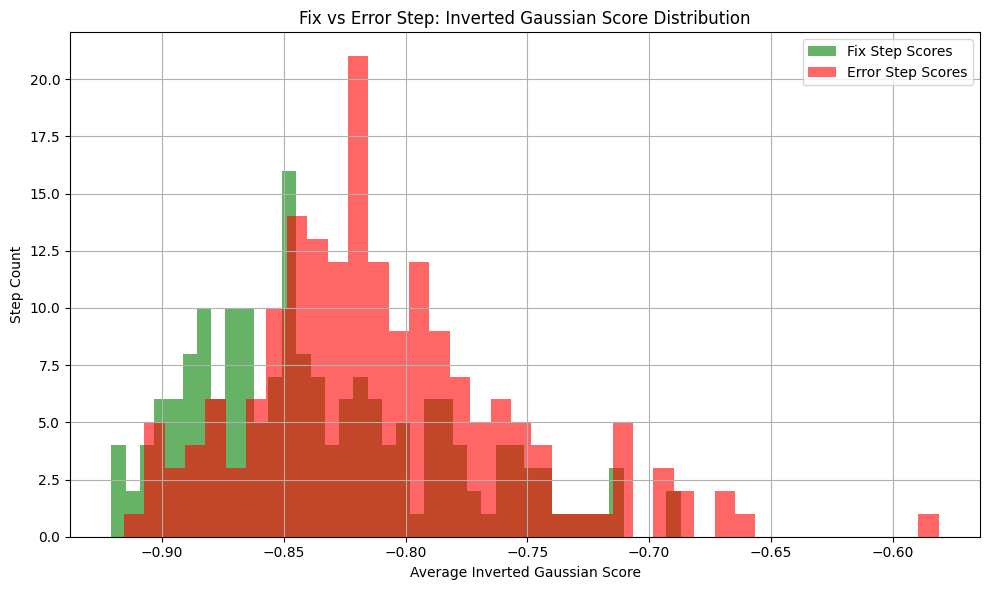

In [ ]:
# 分离 fix 和 error 的倒高斯得分
fix_scores = df_steps[df_steps["type"] == "fix"]["avg_inverted_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["avg_inverted_score"].values

# 绘图
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')
plt.xlabel('Average Inverted Gaussian Score')
plt.ylabel('Step Count')
plt.title('Fix vs Error Step: Inverted Gaussian Score Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


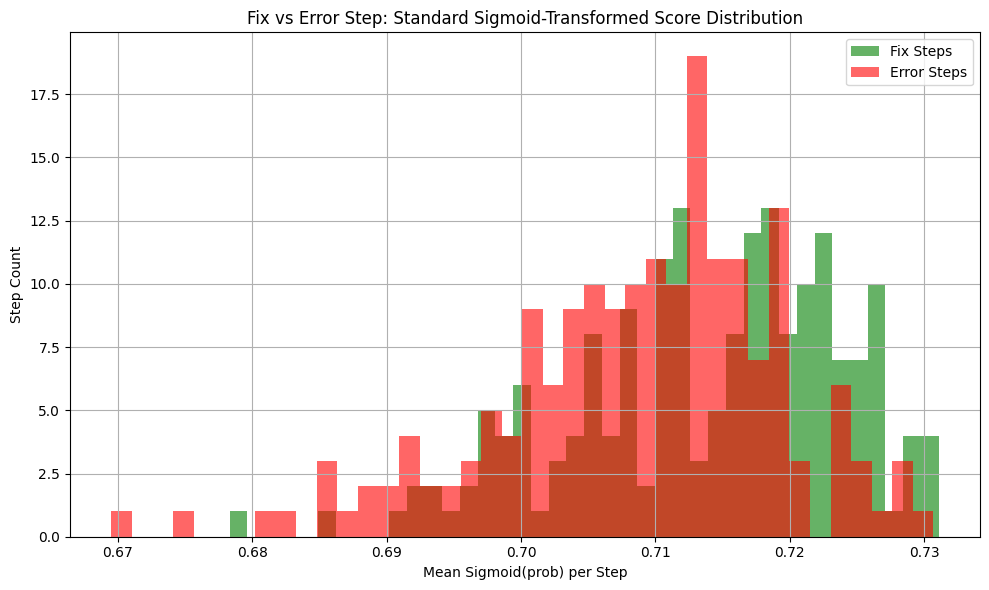

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def avg_sigmoid_score_std(probs):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid(probs))
df_steps["avg_sigmoid_score_std"] = df_steps["probs"].apply(avg_sigmoid_score_std)
fix_scores = df_steps[df_steps["type"] == "fix"]["avg_sigmoid_score_std"].values
error_scores = df_steps[df_steps["type"] == "error"]["avg_sigmoid_score_std"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Steps', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Steps', color='red')
plt.xlabel("Mean Sigmoid(prob) per Step")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Standard Sigmoid-Transformed Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


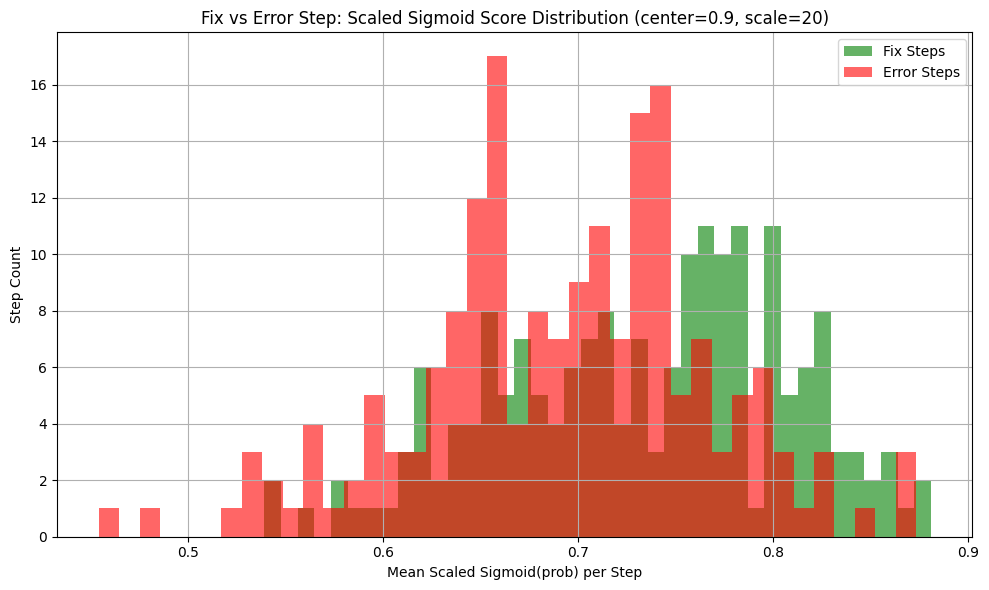

In [ ]:
def sigmoid_scaled(x, center=0.9, scale=20):
    return 1 / (1 + np.exp(-scale * (x - center)))
def avg_sigmoid_score_scaled(probs, center=0.9, scale=20):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid_scaled(probs, center=center, scale=scale))
# 应用 sigmoid(center=0.9, scale=20)
df_steps["avg_sigmoid_score_scaled"] = df_steps["probs"].apply(
    lambda x: avg_sigmoid_score_scaled(x, center=0.9, scale=20)
)
fix_scores = df_steps[df_steps["type"] == "fix"]["avg_sigmoid_score_scaled"].values
error_scores = df_steps[df_steps["type"] == "error"]["avg_sigmoid_score_scaled"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Steps', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Steps', color='red')
plt.xlabel("Mean Scaled Sigmoid(prob) per Step")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Scaled Sigmoid Score Distribution (center=0.9, scale=20)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


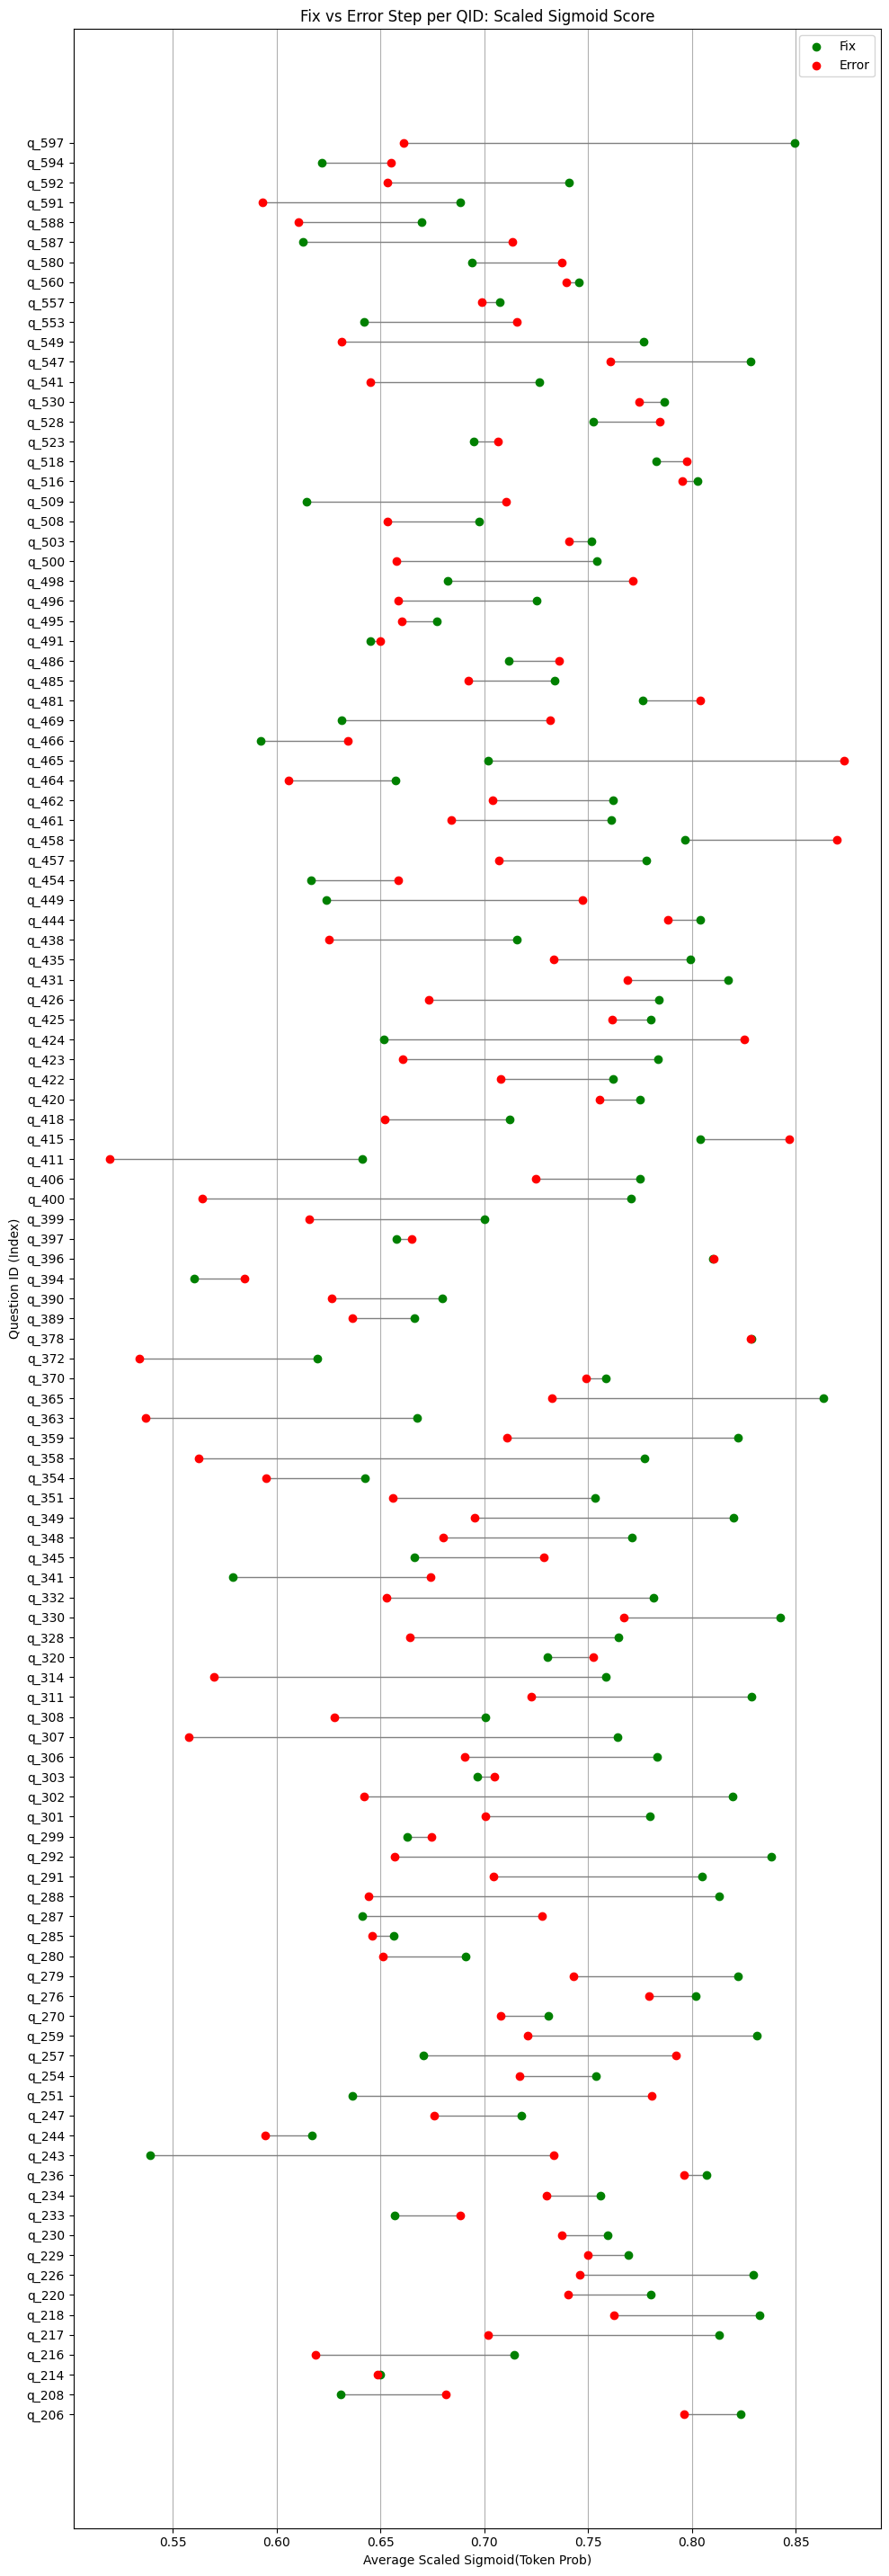

In [ ]:
fix_df = df_steps[df_steps["type"] == "fix"].groupby("qid").first().reset_index()
error_df = df_steps[df_steps["type"] == "error"].groupby("qid").first().reset_index()

merged_df = pd.merge(
    fix_df[["qid", "avg_sigmoid_score_scaled"]],
    error_df[["qid", "avg_sigmoid_score_scaled"]],
    on="qid", suffixes=("_fix", "_error")
)
plt.figure(figsize=(10, len(merged_df) * 0.25))  # 可选压缩高度

# 每条线
for i in range(len(merged_df)):
    plt.plot(
        [merged_df.loc[i, "avg_sigmoid_score_scaled_fix"], merged_df.loc[i, "avg_sigmoid_score_scaled_error"]],
        [i, i],
        color="gray",
        linewidth=1
    )

# 点
plt.scatter(merged_df["avg_sigmoid_score_scaled_fix"], range(len(merged_df)), color="green", label="Fix", zorder=3)
plt.scatter(merged_df["avg_sigmoid_score_scaled_error"], range(len(merged_df)), color="red", label="Error", zorder=3)

# 美化
plt.xlabel("Average Scaled Sigmoid(Token Prob)")
plt.ylabel("Question ID (Index)")
plt.title("Fix vs Error Step per QID: Scaled Sigmoid Score")
plt.yticks(ticks=range(len(merged_df)), labels=merged_df["qid"])
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()


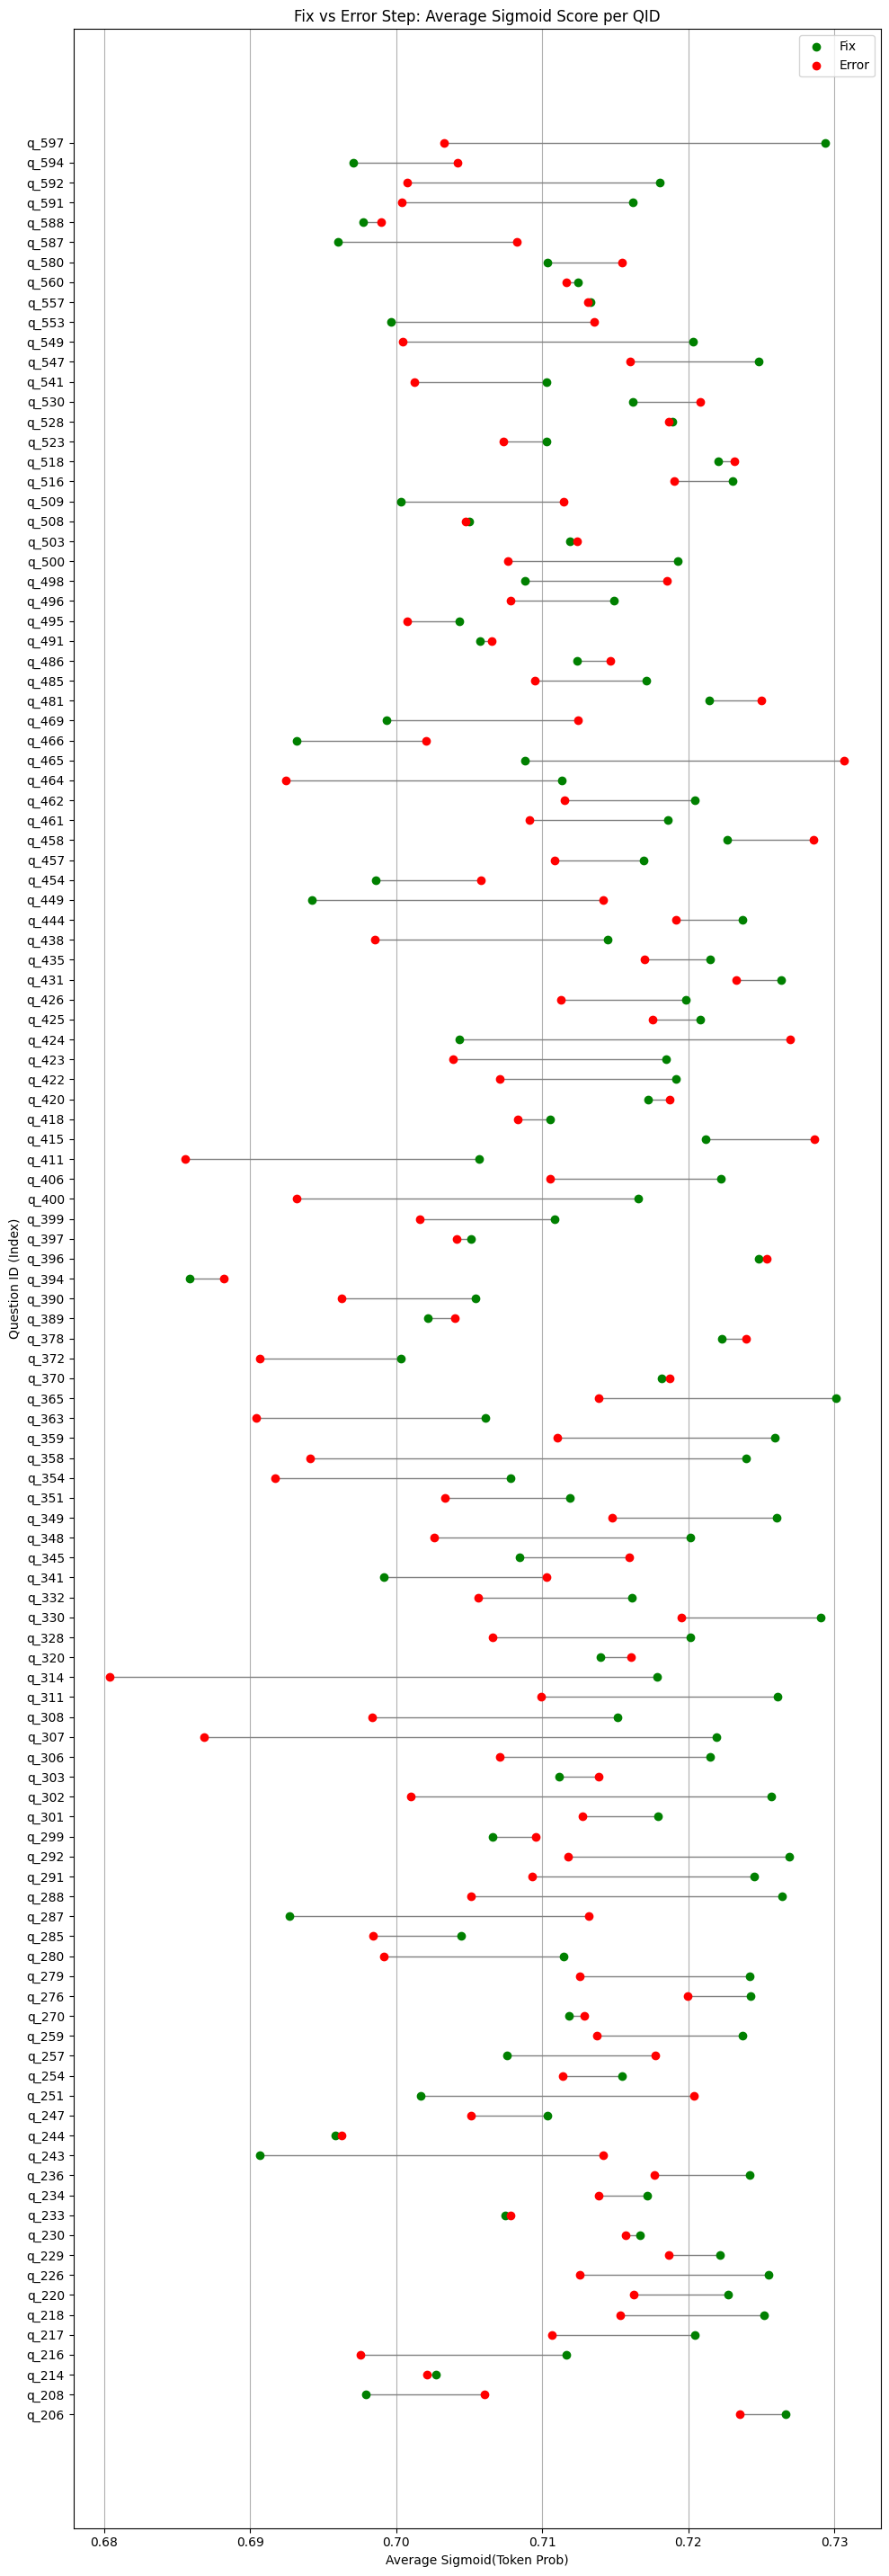

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def avg_sigmoid_score(probs):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    return np.mean(sigmoid(probs))
# 写入列
df_steps["avg_sigmoid_score"] = df_steps["probs"].apply(avg_sigmoid_score)
# 每个 qid 保留一个 fix 和 error
fix_df = df_steps[df_steps["type"] == "fix"].groupby("qid").first().reset_index()
error_df = df_steps[df_steps["type"] == "error"].groupby("qid").first().reset_index()

# 合并为同一个 qid 的配对
merged_df = pd.merge(fix_df[["qid", "avg_sigmoid_score"]],
                     error_df[["qid", "avg_sigmoid_score"]],
                     on="qid", suffixes=("_fix", "_error"))
plt.figure(figsize=(10, len(merged_df) * 0.25))

# 画横线（哑铃）
for i in range(len(merged_df)):
    plt.plot(
        [merged_df.loc[i, "avg_sigmoid_score_fix"], merged_df.loc[i, "avg_sigmoid_score_error"]],
        [i, i],
        color="gray",
        linewidth=1
    )

# 两端点：Fix / Error
plt.scatter(merged_df["avg_sigmoid_score_fix"], range(len(merged_df)), color="green", label="Fix", zorder=3)
plt.scatter(merged_df["avg_sigmoid_score_error"], range(len(merged_df)), color="red", label="Error", zorder=3)

# 图形美化
plt.xlabel("Average Sigmoid(Token Prob)")
plt.ylabel("Question ID (Index)")
plt.title("Fix vs Error Step: Average Sigmoid Score per QID")
plt.yticks(ticks=range(len(merged_df)), labels=merged_df["qid"])
plt.grid(True, axis='x')
plt.legend()
plt.tight_layout()
plt.show()


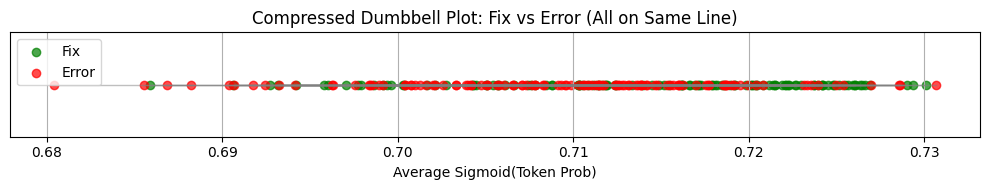

In [ ]:
plt.figure(figsize=(10, 2))  # 宽但高度压缩

# 所有横线都在 y=0
for i in range(len(merged_df)):
    plt.plot(
        [merged_df.loc[i, "avg_sigmoid_score_fix"], merged_df.loc[i, "avg_sigmoid_score_error"]],
        [0, 0],  # 所有线都在 y=0
        color="gray",
        linewidth=1,
        alpha=0.5
    )

# 散点
plt.scatter(merged_df["avg_sigmoid_score_fix"], [0]*len(merged_df), color="green", label="Fix", alpha=0.7)
plt.scatter(merged_df["avg_sigmoid_score_error"], [0]*len(merged_df), color="red", label="Error", alpha=0.7)

# 美化
plt.xlabel("Average Sigmoid(Token Prob)")
plt.yticks([])  # 隐藏 y 轴
plt.title("Compressed Dumbbell Plot: Fix vs Error (All on Same Line)")
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

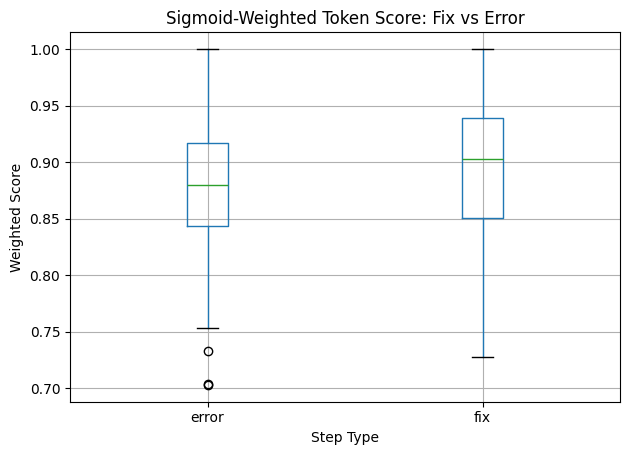

In [ ]:
# ✅ 构造对称 Sigmoid 权重函数（两端高，中间低）
def symmetric_sigmoid_weights(length, scale=10):
    # 生成线性位置索引 [-1, 1]
    x = np.linspace(-1, 1, length)
    # 中间低，两端高的 sigmoid 权重：使用 1 - sigmoid
    weights = 1 - 1 / (1 + np.exp(-scale * x))
    return weights / weights.sum()  # 归一化

# ✅ 应用：对 step 中所有 token 的概率加权求平均
def weighted_sigmoid_score(probs, scale=10):
    if len(probs) < 2:
        return np.mean(probs)
    probs = np.array(probs)
    weights = symmetric_sigmoid_weights(len(probs), scale=scale)
    return np.sum(weights * probs)

# ✅ 添加新列到 DataFrame 中
df_steps["weighted_sigmoid_score"] = df_steps["probs"].apply(
    lambda x: weighted_sigmoid_score(x, scale=10)
)

# ✅ 可视化对比 boxplot
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="weighted_sigmoid_score", by="type")
plt.title("Sigmoid-Weighted Token Score: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Weighted Score")
plt.grid(True)
plt.tight_layout()
plt.show()


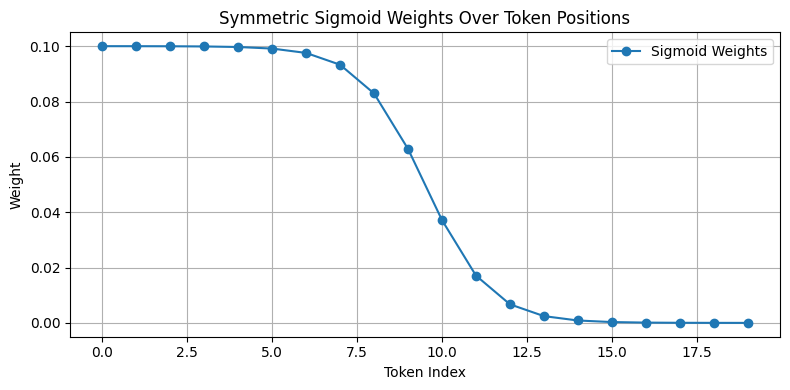

In [ ]:
# 可视化 sigmoid 权重分布
length = 20
weights = symmetric_sigmoid_weights(length, scale=10)

plt.figure(figsize=(8, 4))
plt.plot(range(length), weights, marker='o', label='Sigmoid Weights')
plt.title("Symmetric Sigmoid Weights Over Token Positions")
plt.xlabel("Token Index")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


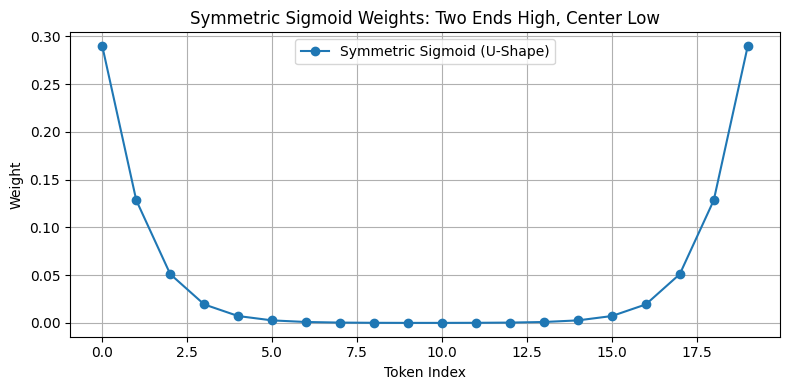

In [ ]:
def symmetric_sigmoid_weights(length, scale=10):
    if length < 2:
        return np.array([1.0])

    # 创建左半边的 sigmoid 权重：从高（边缘）到低（中心）
    half_len = length // 2
    x = np.linspace(-1, 0, half_len, endpoint=False)
    left_half = 1 / (1 + np.exp(-scale * x))  # sigmoid：边缘高，中心低
    left_half = left_half[::-1]  # 翻转，从边缘高 → 中间低

    # 右半边对称
    right_half = left_half[::-1] if length % 2 == 0 else np.concatenate([[left_half[0]], left_half[::-1]])

    # 拼接两边
    weights = np.concatenate([left_half, right_half])
    return weights / weights.sum()  # 归一化
length = 20
weights = symmetric_sigmoid_weights(length, scale=10)

plt.figure(figsize=(8, 4))
plt.plot(range(length), weights, marker='o', label='Symmetric Sigmoid (U-Shape)')
plt.title("Symmetric Sigmoid Weights: Two Ends High, Center Low")
plt.xlabel("Token Index")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


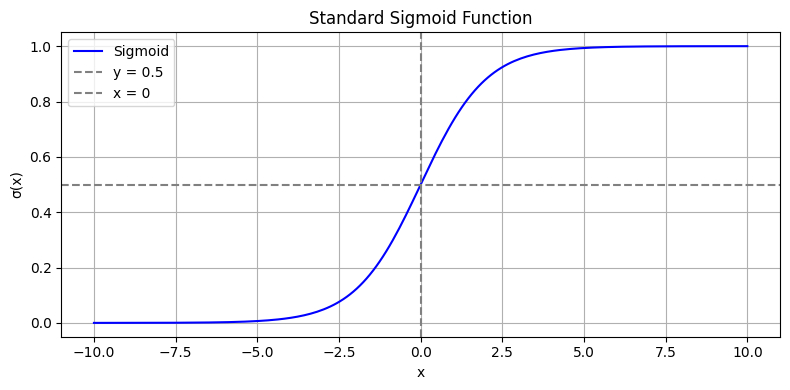

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 定义 sigmoid 函数
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 生成 x 区间 [-10, 10]
x = np.linspace(-10, 10, 200)
y = sigmoid(x)

# 可视化
plt.figure(figsize=(8, 4))
plt.plot(x, y, label="Sigmoid", color="blue")
plt.axhline(0.5, color="gray", linestyle="--", label="y = 0.5")
plt.axvline(0, color="gray", linestyle="--", label="x = 0")
plt.title("Standard Sigmoid Function")
plt.xlabel("x")
plt.ylabel("σ(x)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

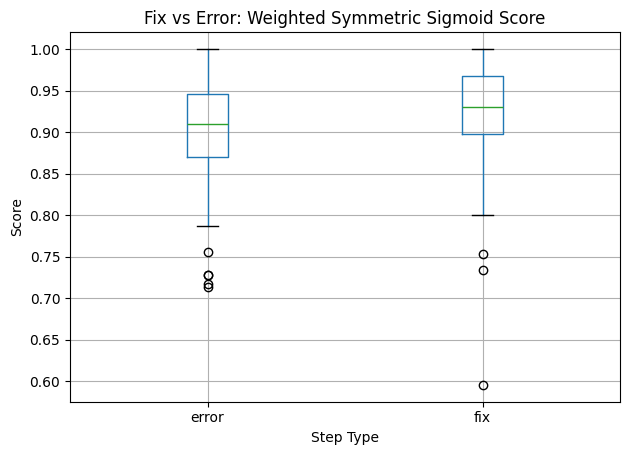

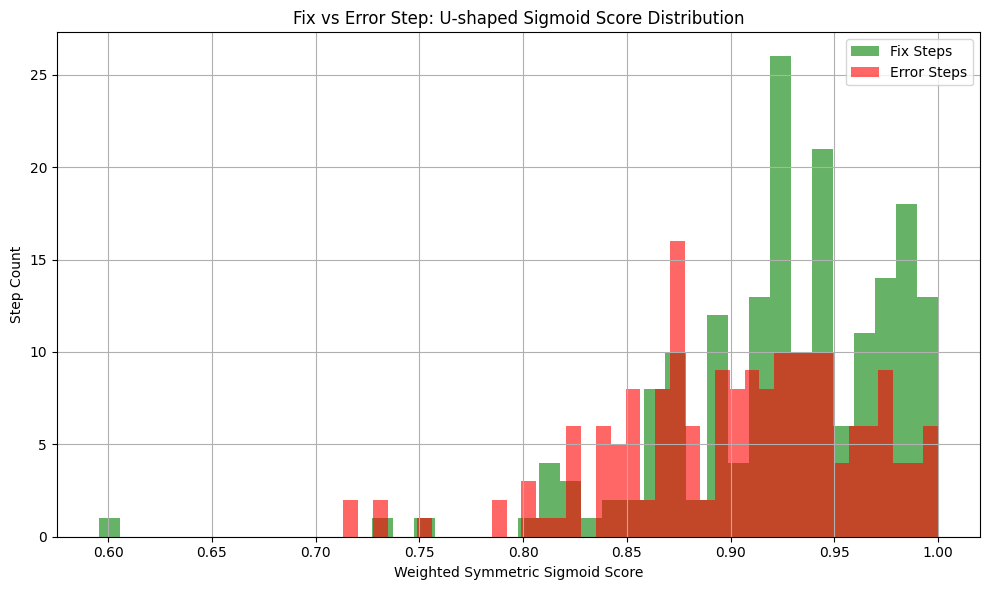

In [ ]:
def weighted_symmetric_sigmoid_score(probs, scale=10):
    if len(probs) < 2:
        return np.mean(probs)
    probs = np.array(probs)
    weights = symmetric_sigmoid_weights(len(probs), scale=scale)
    return np.sum(weights * probs)

# 写入新列
df_steps["weighted_symmetric_sigmoid_score"] = df_steps["probs"].apply(
    lambda x: weighted_symmetric_sigmoid_score(x, scale=10)
)

plt.figure(figsize=(6, 5))
df_steps.boxplot(column="weighted_symmetric_sigmoid_score", by="type")
plt.title("Fix vs Error: Weighted Symmetric Sigmoid Score")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()

fix_scores = df_steps[df_steps["type"] == "fix"]["weighted_symmetric_sigmoid_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["weighted_symmetric_sigmoid_score"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label="Fix Steps", color="green")
plt.hist(error_scores, bins=40, alpha=0.6, label="Error Steps", color="red")
plt.xlabel("Weighted Symmetric Sigmoid Score")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: U-shaped Sigmoid Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

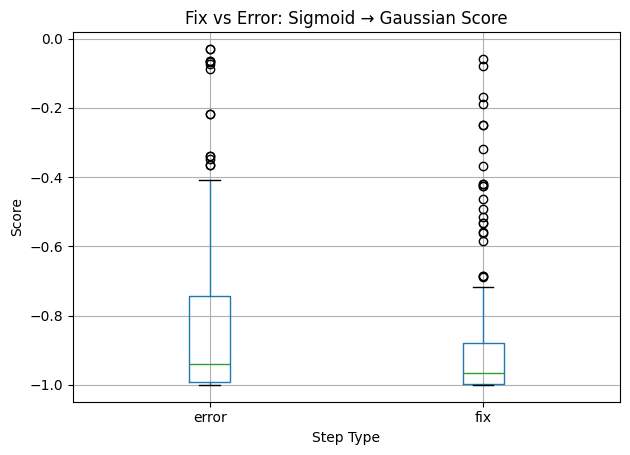

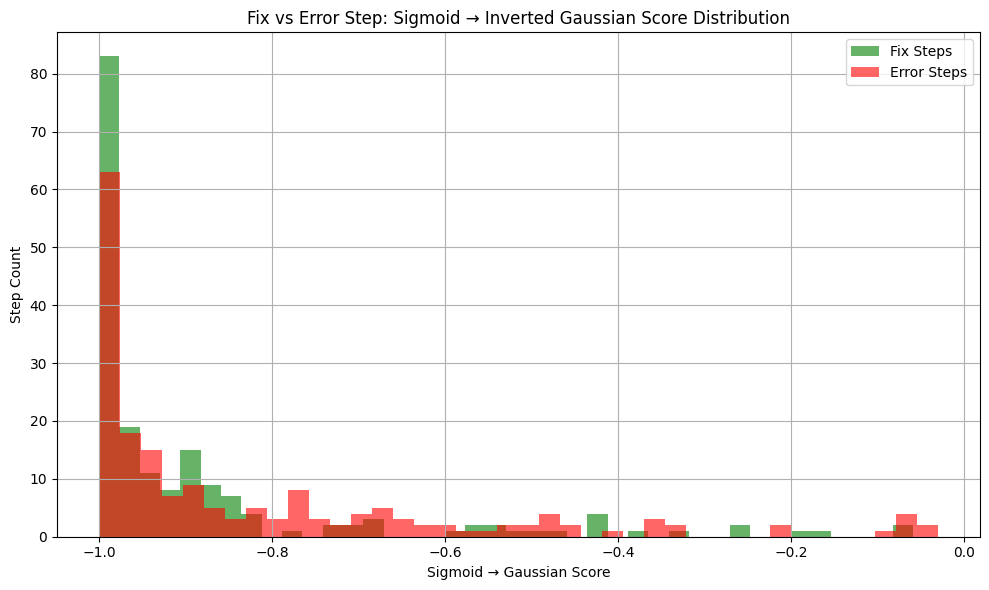

In [ ]:
def sigmoid_then_gauss_score(probs, sig_scale=10, gauss_mu=0.5, gauss_sigma=0.1):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    weights = symmetric_sigmoid_weights(len(probs), scale=sig_scale)
    weighted_avg = np.sum(weights * probs)
    return inverted_gaussian(weighted_avg, mu=gauss_mu, sigma=gauss_sigma)
df_steps["sigmoid_then_gauss_score"] = df_steps["probs"].apply(
    lambda x: sigmoid_then_gauss_score(x, sig_scale=30, gauss_mu=1, gauss_sigma=sigma_est * 0.7)
)

plt.figure(figsize=(6, 5))
df_steps.boxplot(column="sigmoid_then_gauss_score", by="type")
plt.title("Fix vs Error: Sigmoid → Gaussian Score")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()
fix_scores = df_steps[df_steps["type"] == "fix"]["sigmoid_then_gauss_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["sigmoid_then_gauss_score"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label="Fix Steps", color="green")
plt.hist(error_scores, bins=40, alpha=0.6, label="Error Steps", color="red")
plt.xlabel("Sigmoid → Gaussian Score")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Sigmoid → Inverted Gaussian Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# version 2 relu
def symmetric_relu_weights(length, scale=1.0):
    """
    返回一个对称的、两端高中间低的权重分布。
    可用于强调 step 中靠近开头和结尾的 token。
    """
    if length < 2:
        return np.array([1.0])

    center = (length - 1) / 2
    distances = np.abs(np.arange(length) - center)

    # 归一化距离，让中心为 0，端点为 1，然后反转
    max_dist = distances.max()
    weights = distances / max_dist  # 中间是 0，边缘是 1
    weights = weights ** scale      # 可调非线性程度
    return weights / weights.sum()  # 归一化


In [ ]:
def weighted_relu_score(probs, scale=1.0):
    if len(probs) < 2:
        return np.mean(probs)
    probs = np.array(probs)
    weights = symmetric_relu_weights(len(probs), scale=scale)
    return np.sum(weights * probs)


In [ ]:
# 应用到 DataFrame
df_steps["weighted_relu_score"] = df_steps["probs"].apply(
    lambda probs: np.sum(symmetric_relu_weights(len(probs), scale=1.0) * np.array(probs))
)

<Figure size 600x500 with 0 Axes>

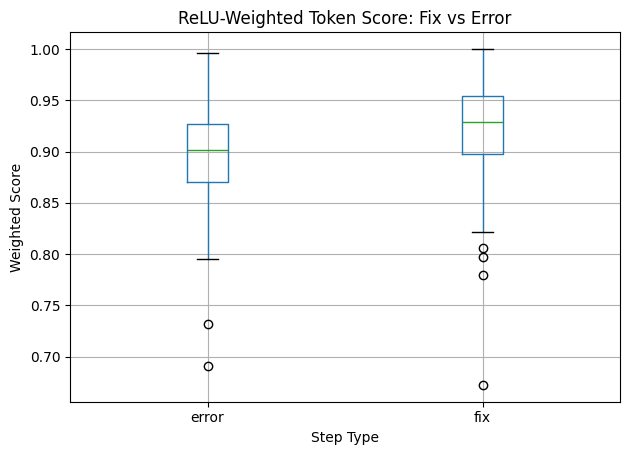

In [ ]:
# ✅ 可视化对比 boxplot
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="weighted_relu_score", by="type")
plt.title("ReLU-Weighted Token Score: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Weighted Score")
plt.grid(True)
plt.tight_layout()
plt.show()

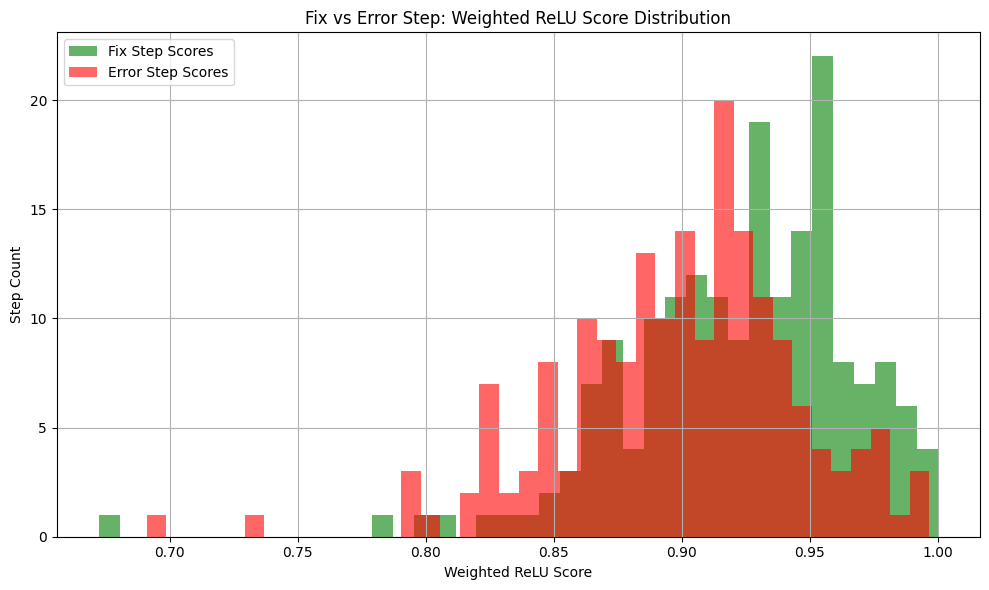

In [ ]:
# 提取 Fix 和 Error 的 weighted_relu_score 分数
fix_scores = df_steps[df_steps["type"] == "fix"]["weighted_relu_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["weighted_relu_score"].values

# ✅ 画重叠直方图
plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')

# ✅ 图形设置
plt.xlabel("Weighted ReLU Score")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Weighted ReLU Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


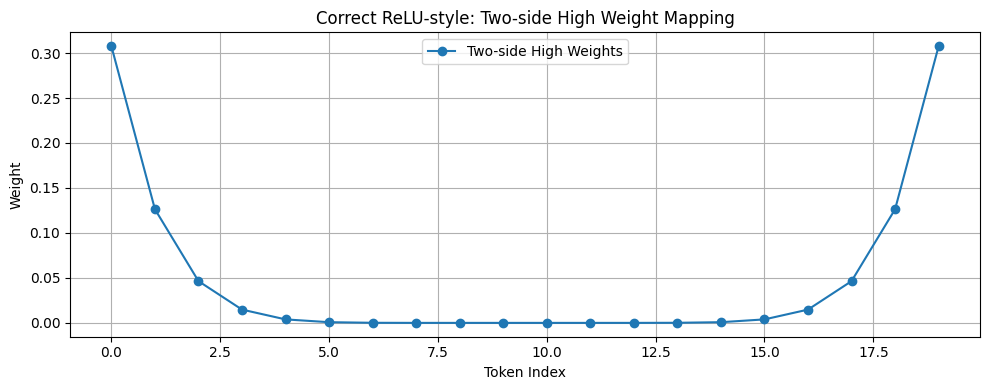

In [ ]:
# 可视化新的两端高权重
length = 20
weights = symmetric_relu_weights(length, scale=8.0)

plt.figure(figsize=(10, 4))
plt.plot(range(length), weights, marker='o', label='Two-side High Weights')
plt.title("Correct ReLU-style: Two-side High Weight Mapping")
plt.xlabel("Token Index")
plt.ylabel("Weight")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

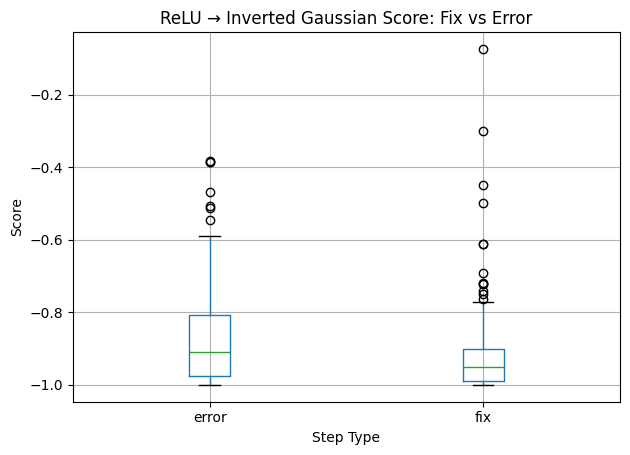

In [ ]:
def relu_then_gauss_score(probs, relu_scale=1.0, mu=0.5, sigma=0.1):
    if len(probs) < 2:
        return 0.0  # 避免异常情况
    probs = np.array(probs)
    weights = symmetric_relu_weights(len(probs), scale=relu_scale)
    weighted_avg = np.sum(weights * probs)
    return inverted_gaussian(weighted_avg, mu=mu, sigma=sigma)
df_steps["relu_then_gauss_score"] = df_steps["probs"].apply(
    lambda probs: relu_then_gauss_score(probs, relu_scale=8.0, mu=1, sigma=sigma_est)
)
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="relu_then_gauss_score", by="type")
plt.title("ReLU → Inverted Gaussian Score: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
mu_est

np.float64(0.9121320808926074)

In [ ]:
sigma_est

np.float64(0.2072006482172411)

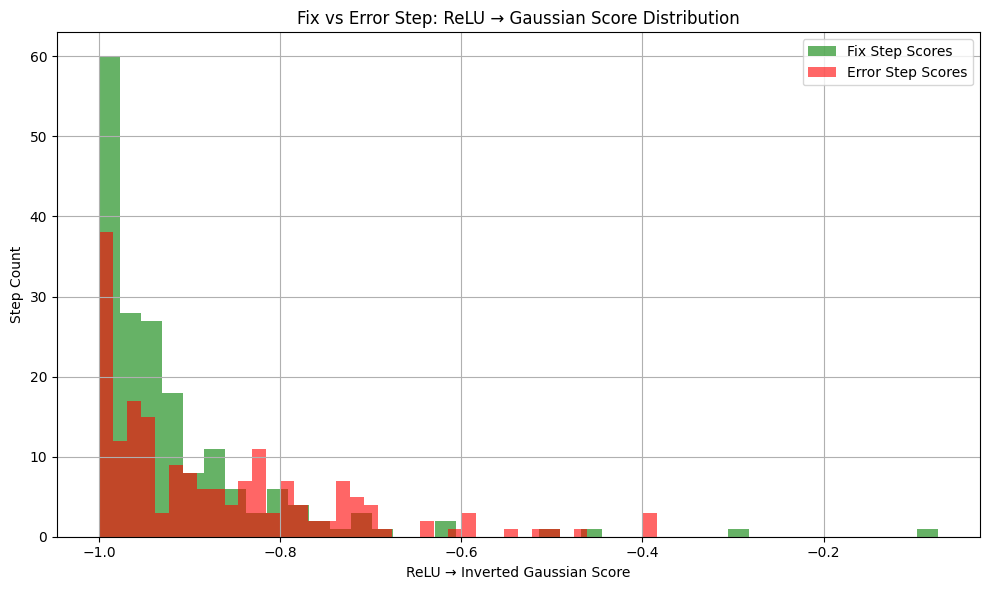

In [ ]:
# 分离 Fix 和 Error 的 ReLU→Gaussian 分数
fix_scores = df_steps[df_steps["type"] == "fix"]["relu_then_gauss_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["relu_then_gauss_score"].values

# ✅ 绘图：重叠直方图
plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')

# ✅ 图形设置
plt.xlabel('ReLU → Inverted Gaussian Score')
plt.ylabel('Step Count')
plt.title('Fix vs Error Step: ReLU → Gaussian Score Distribution')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


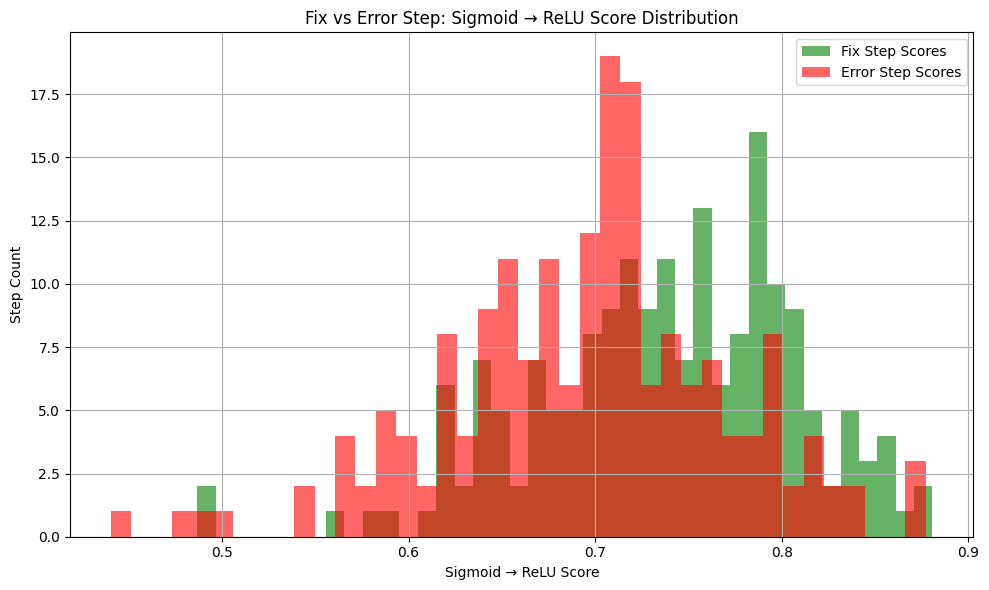

In [ ]:
def sigmoid_then_relu_score(probs, sig_center=0.9, sig_scale=20, relu_scale=1.0):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)

    # Step 1: Sigmoid transform on probs
    sig_scores = 1 / (1 + np.exp(-sig_scale * (probs - sig_center)))
    # print(sig_scores)

    # Step 2: ReLU-style positional weighting
    weights = symmetric_relu_weights(len(probs), scale=relu_scale)

    return np.sum(sig_scores * weights)
df_steps["sigmoid_then_relu_score"] = df_steps["probs"].apply(
    lambda x: sigmoid_then_relu_score(x, sig_center=0.9, sig_scale=20, relu_scale=1.0)
)
fix_scores = df_steps[df_steps["type"] == "fix"]["sigmoid_then_relu_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["sigmoid_then_relu_score"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')
plt.xlabel("Sigmoid → ReLU Score")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Sigmoid → ReLU Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


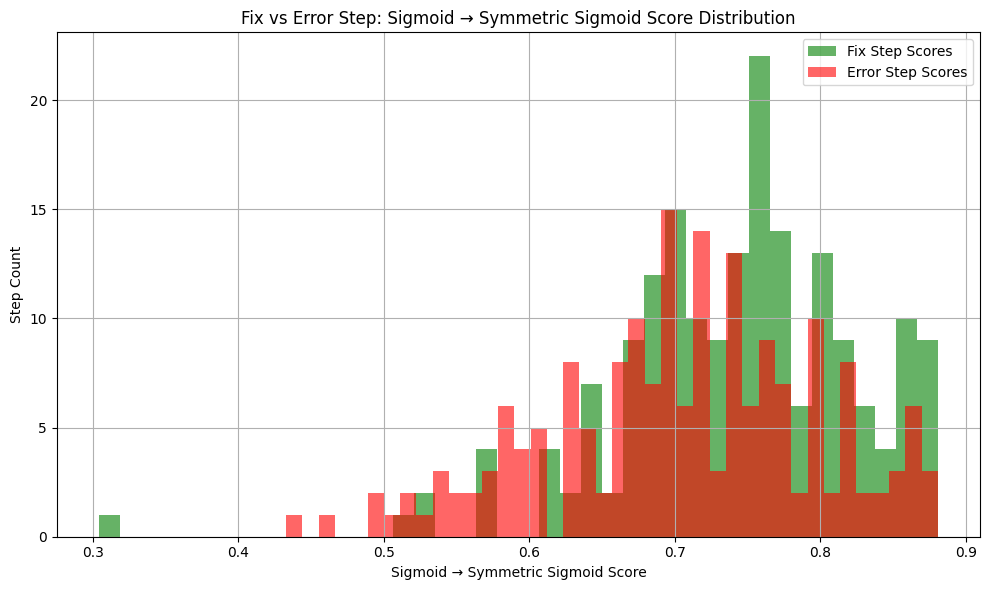

In [ ]:
# ✅ 主函数：sigmoid → symmetric sigmoid 加权
def sigmoid_then_symmetric_sigmoid_score(probs, sig_center=0.9, sig_scale=20, weight_scale=10):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)

    # Step 1: sigmoid 映射（非线性强调高 prob token）
    sig_scores = 1 / (1 + np.exp(-sig_scale * (probs - sig_center)))

    # Step 2: 对称 sigmoid 位置权重
    weights = symmetric_sigmoid_weights(len(probs), scale=weight_scale)

    return np.sum(sig_scores * weights)
df_steps["sigmoid_then_symmetric_sigmoid_score"] = df_steps["probs"].apply(
    lambda x: sigmoid_then_symmetric_sigmoid_score(x, sig_center=0.9, sig_scale=20, weight_scale=10)
)
fix_scores = df_steps[df_steps["type"] == "fix"]["sigmoid_then_symmetric_sigmoid_score"].values
error_scores = df_steps[df_steps["type"] == "error"]["sigmoid_then_symmetric_sigmoid_score"].values

plt.figure(figsize=(10, 6))
plt.hist(fix_scores, bins=40, alpha=0.6, label='Fix Step Scores', color='green')
plt.hist(error_scores, bins=40, alpha=0.6, label='Error Step Scores', color='red')
plt.xlabel("Sigmoid → Symmetric Sigmoid Score")
plt.ylabel("Step Count")
plt.title("Fix vs Error Step: Sigmoid → Symmetric Sigmoid Score Distribution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

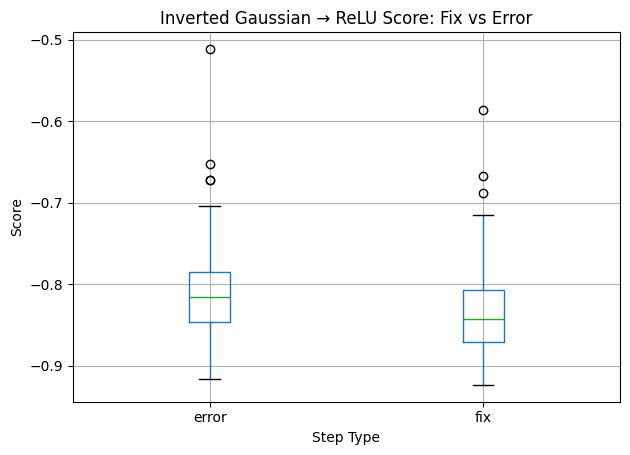

In [ ]:
def gauss_then_relu_score(probs, relu_scale=1.0, mu=0.5, sigma=0.1):
    if len(probs) < 2:
        return 0.0
    probs = np.array(probs)
    gauss_scores = inverted_gaussian(probs, mu=mu, sigma=sigma)
    weights = symmetric_relu_weights(len(probs), scale=relu_scale)
    return np.sum(weights * gauss_scores)
df_steps["gauss_then_relu_score"] = df_steps["probs"].apply(
    lambda probs: gauss_then_relu_score(probs, relu_scale=1.0, mu=mu_est, sigma=sigma_est)
)
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="gauss_then_relu_score", by="type")
plt.title("Inverted Gaussian → ReLU Score: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

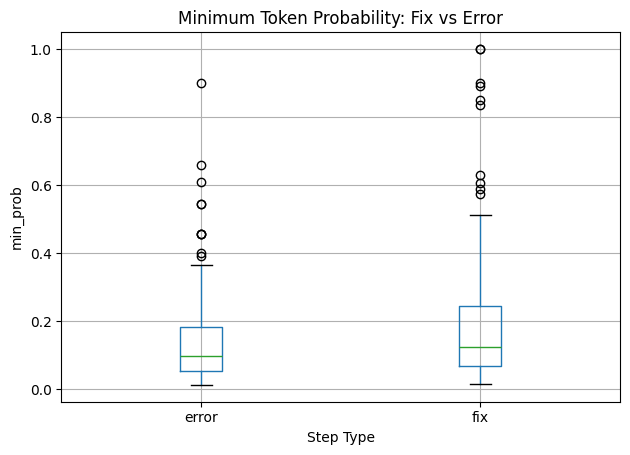

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="min_prob", by="type")
plt.title("Minimum Token Probability: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("min_prob")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

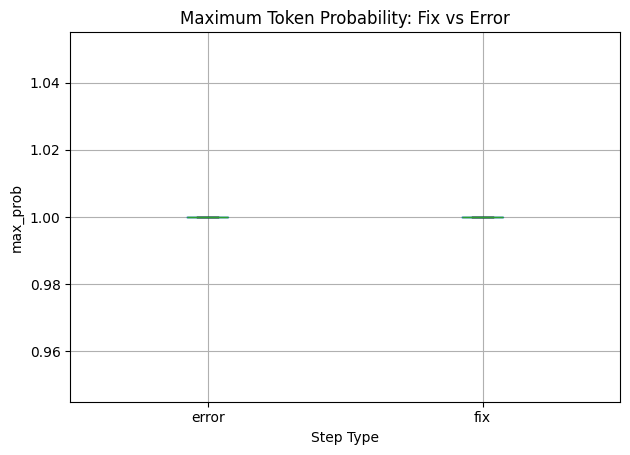

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="max_prob", by="type")
plt.title("Maximum Token Probability: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("max_prob")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

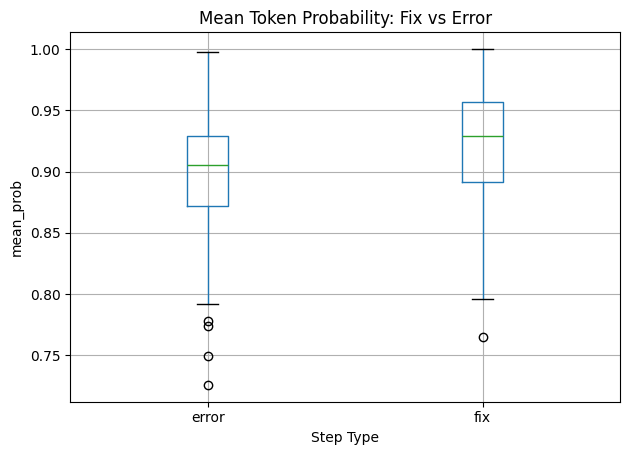

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="mean_prob", by="type")
plt.title("Mean Token Probability: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("mean_prob")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

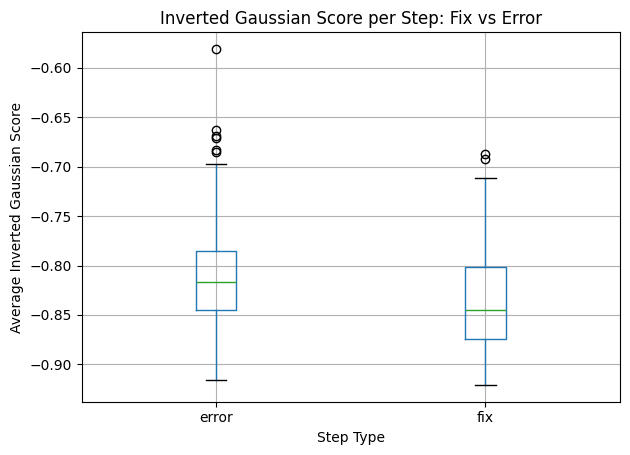

In [ ]:
# ========== 📊 可视化：倒高斯打分 Fix vs Error ==========
plt.figure(figsize=(10, 6))
df_steps.boxplot(column="avg_inverted_score", by="type")
plt.title("Inverted Gaussian Score per Step: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Average Inverted Gaussian Score")
plt.grid(True)
plt.tight_layout()
plt.show()


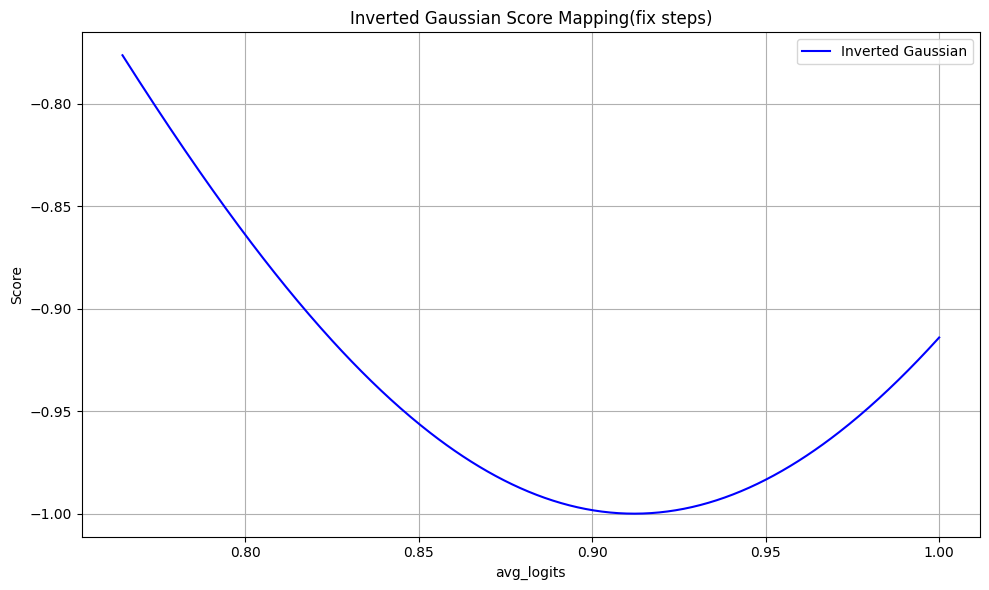

In [ ]:

# ========== 📉 倒高斯函数映射图（基于 fix_step 的 mean_prob） ==========
fix_mean_logits = df_steps[df_steps["type"] == "fix"]["mean_prob"].values
x_vals = np.linspace(min(fix_mean_logits), max(fix_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping(fix steps)")
plt.xlabel("avg_logits")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


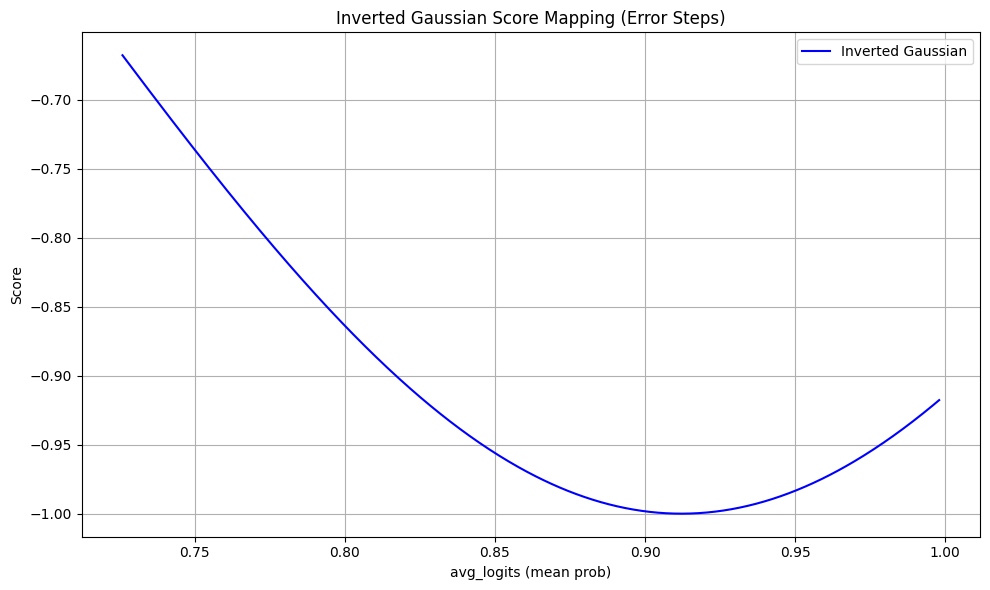

In [ ]:
# ========== 📉 倒高斯函数映射图（基于 error_step 的 mean_prob） ==========
error_mean_logits = df_steps[df_steps["type"] == "error"]["mean_prob"].values
x_vals = np.linspace(min(error_mean_logits), max(error_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")
plt.title("Inverted Gaussian Score Mapping (Error Steps)")
plt.xlabel("avg_logits (mean prob)")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


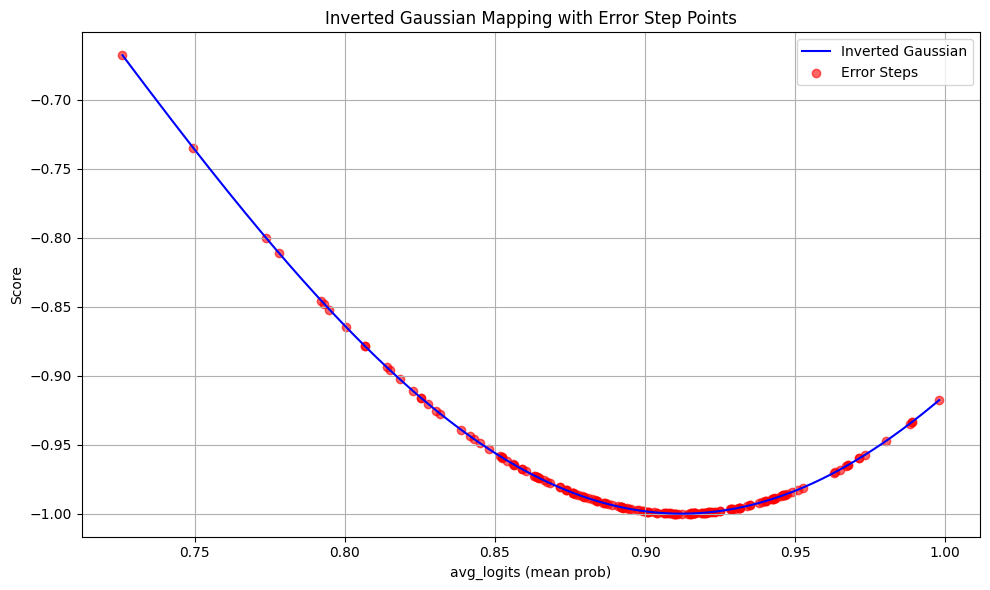

In [ ]:
plt.figure(figsize=(10, 6))
x_vals = np.linspace(min(error_mean_logits), max(error_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

# 绘制倒高斯函数
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")

# 🔴 叠加 error step 的点
plt.scatter(
    error_mean_logits,
    inverted_gaussian(error_mean_logits, mu=mu_est, sigma=sigma_est),
    color="red",
    alpha=0.6,
    label="Error Steps"
)

plt.title("Inverted Gaussian Mapping with Error Step Points")
plt.xlabel("avg_logits (mean prob)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


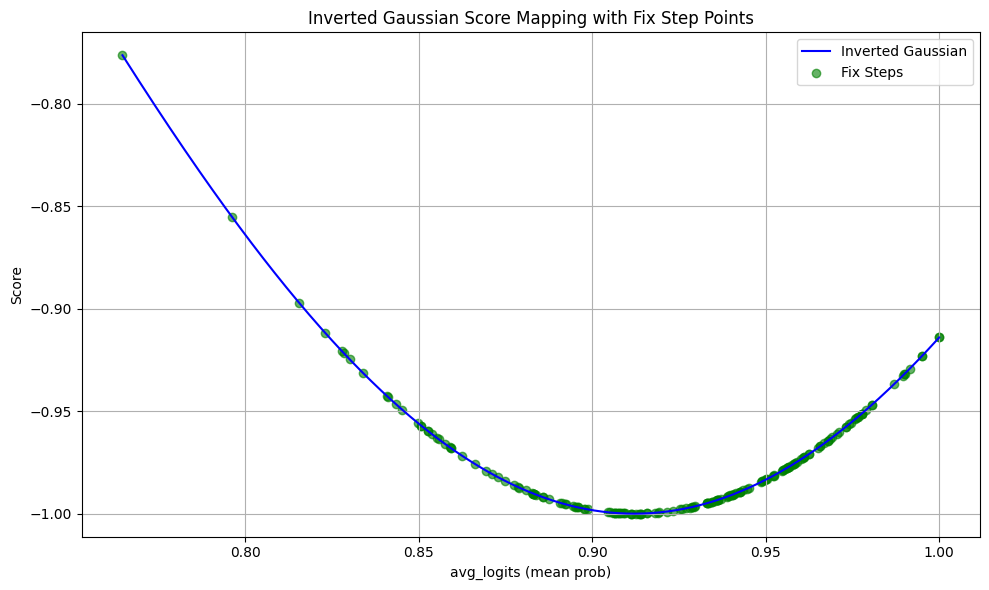

In [ ]:
# ========== 📉 倒高斯函数映射图 + 叠加 fix_step 点 ==========
fix_mean_logits = df_steps[df_steps["type"] == "fix"]["mean_prob"].values
x_vals = np.linspace(min(fix_mean_logits), max(fix_mean_logits), 500)
y_vals = inverted_gaussian(x_vals, mu=mu_est, sigma=sigma_est)

# 📊 绘图
plt.figure(figsize=(10, 6))

# 倒高斯曲线
plt.plot(x_vals, y_vals, label="Inverted Gaussian", color="blue")

# 叠加真实 fix_step 点
plt.scatter(
    fix_mean_logits,
    inverted_gaussian(fix_mean_logits, mu=mu_est, sigma=sigma_est),
    color="green",
    alpha=0.6,
    label="Fix Steps"
)

# 图形设置
plt.title("Inverted Gaussian Score Mapping with Fix Step Points")
plt.xlabel("avg_logits (mean prob)")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import entropy

def compute_entropy(probs):
    probs = np.array(probs)
    # 避免 log(0)
    probs = probs[probs > 0]
    if len(probs) == 0:
        return np.nan
    return entropy(probs, base=2)

def top_k_mean(probs, k=10):
    return np.mean(sorted(probs, reverse=True)[:k]) if len(probs) >= k else np.mean(probs)

# 添加新特征列
df_steps["entropy"] = df_steps["probs"].apply(compute_entropy)
df_steps["top10_mean_prob"] = df_steps["probs"].apply(lambda x: top_k_mean(x, k=10))


<Figure size 600x500 with 0 Axes>

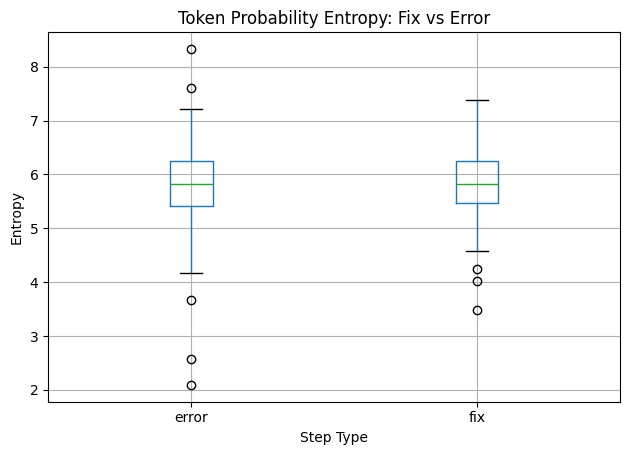

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="entropy", by="type")
plt.title("Token Probability Entropy: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Entropy")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

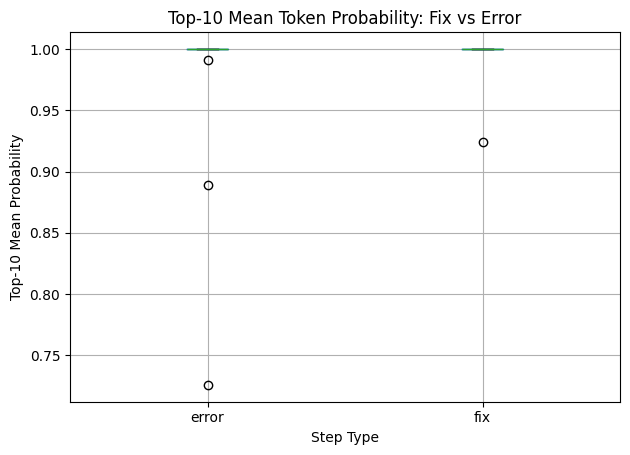

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="top10_mean_prob", by="type")
plt.title("Top-10 Mean Token Probability: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Top-10 Mean Probability")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from scipy.spatial.distance import jensenshannon
import numpy as np
import matplotlib.pyplot as plt

# ✅ Step 1: 归一化函数（避免概率为 0 或求和为 0）
def normalize_probs(p):
    p = np.array(p)
    if p.sum() == 0:
        return np.ones_like(p) / len(p)
    return p / p.sum()

# ✅ Step 2: KL 散度相对于均匀分布
def compute_kl_uniform(p):
    p = normalize_probs(p)
    q = np.ones_like(p) / len(p)  # uniform 分布
    return np.sum(p * np.log(p / q))

# ✅ Step 3: JS 散度相对于均匀分布
def compute_js_uniform(p):
    p = normalize_probs(p)
    q = np.ones_like(p) / len(p)  # uniform 分布
    return jensenshannon(p, q, base=2)

# ✅ Step 4: 应用于 DataFrame
df_steps["kl_div_uniform"] = df_steps["probs"].apply(compute_kl_uniform)
df_steps["js_div_uniform"] = df_steps["probs"].apply(compute_js_uniform)


<Figure size 600x500 with 0 Axes>

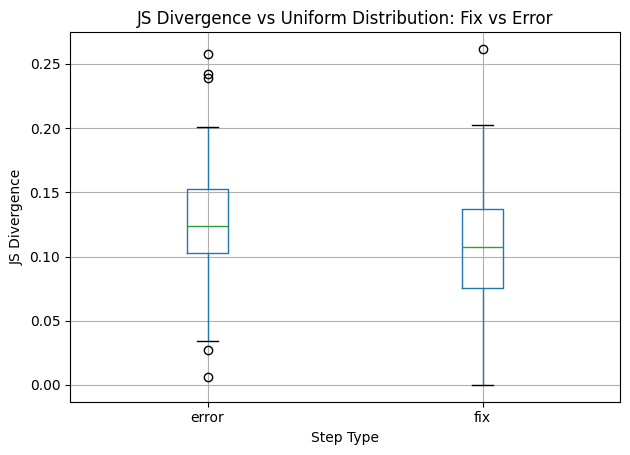

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="js_div_uniform", by="type")
plt.title("JS Divergence vs Uniform Distribution: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("JS Divergence")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

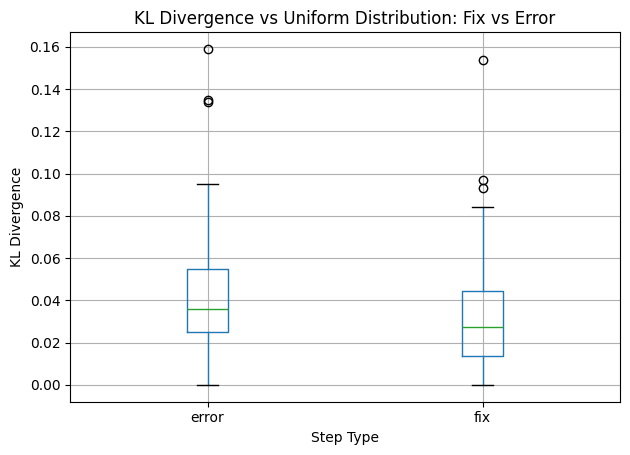

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="kl_div_uniform", by="type")
plt.title("KL Divergence vs Uniform Distribution: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("KL Divergence")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

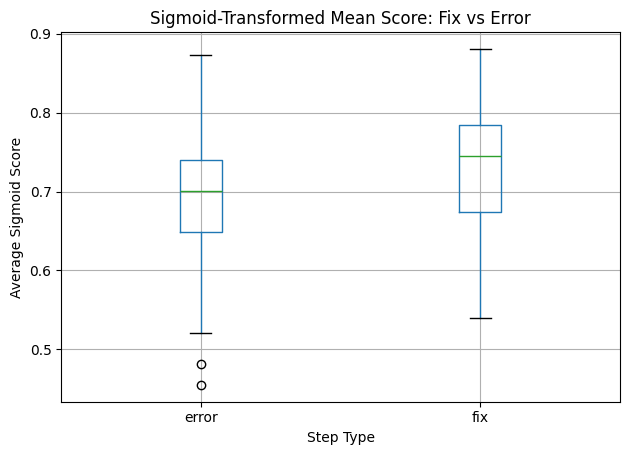

In [ ]:
# ✅ Sigmoid 函数映射
def sigmoid_score(p, center=0.9, scale=20):
    p = np.array(p)
    return 1 / (1 + np.exp(-scale * (p - center)))
# ✅ 添加 Sigmoid 平均得分
df_steps["avg_sigmoid_score"] = df_steps["probs"].apply(
    lambda x: np.mean(sigmoid_score(x, center=0.9, scale=20))
)
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="avg_sigmoid_score", by="type")
plt.title("Sigmoid-Transformed Mean Score: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Average Sigmoid Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
#Z-score/slope/峰值数

from scipy.stats import zscore, linregress
from scipy.signal import argrelextrema
import numpy as np

# ✅ 1. Slope：线性回归斜率
def compute_slope(probs):
    x = np.arange(len(probs))
    y = np.array(probs)
    if len(y) < 2:
        return 0  # 无法拟合
    slope, _, _, _, _ = linregress(x, y)
    return slope

# ✅ 2. 局部极值点（极大 + 极小）
def count_peaks(probs):
    probs = np.array(probs)
    maxima = argrelextrema(probs, np.greater)[0]
    minima = argrelextrema(probs, np.less)[0]
    return len(maxima) + len(minima)
# ✅ 计算 slope 和 peak count
df_steps["slope"] = df_steps["probs"].apply(compute_slope)
df_steps["peak_count"] = df_steps["probs"].apply(count_peaks)

# ✅ 全局标准化 mean_prob（Z-score）
df_steps["mean_zscore"] = zscore(df_steps["mean_prob"])




<Figure size 600x500 with 0 Axes>

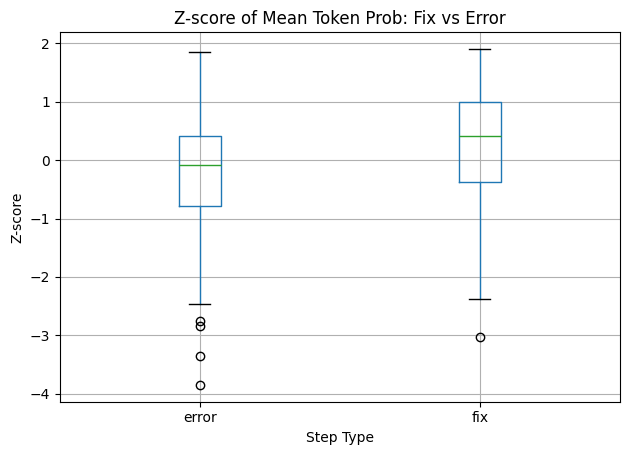

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="mean_zscore", by="type")
plt.title("Z-score of Mean Token Prob: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Z-score")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

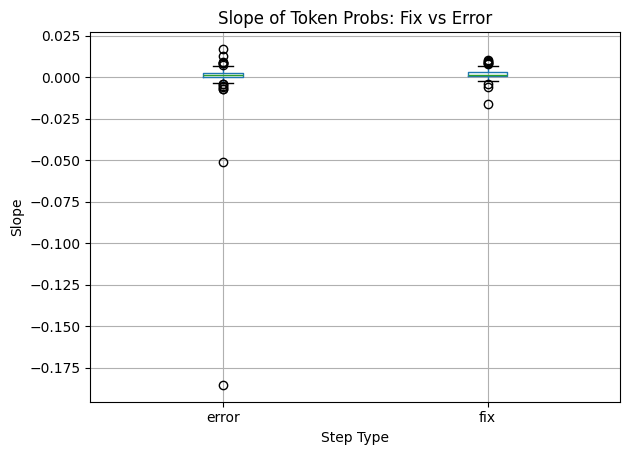

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="slope", by="type")
plt.title("Slope of Token Probs: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Slope")
plt.grid(True)
plt.tight_layout()
plt.show()


<Figure size 600x500 with 0 Axes>

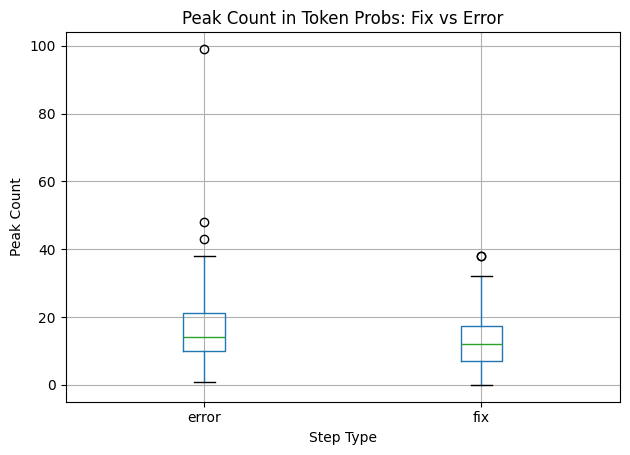

In [ ]:
plt.figure(figsize=(6, 5))
df_steps.boxplot(column="peak_count", by="type")
plt.title("Peak Count in Token Probs: Fix vs Error")
plt.suptitle("")
plt.xlabel("Step Type")
plt.ylabel("Peak Count")
plt.grid(True)
plt.tight_layout()
plt.show()
